In [164]:
import numpy as np
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import pandas as pd
import glob
import fnmatch
import os
import SimpleITK as sitk

# ANNOTATIONS

The annotation file is a csv file that contains one finding per line. Each line holds the SeriesInstanceUID of the scan, the x, y, and z position of each finding in world coordinates; and the corresponding diameter in mm. The annotation file contains 1186 nodules.

The list of annotations that are not used as reference standard will be provided. Each line holds the SeriesInstanceUID of the scan, the x, y, and z position of each finding in world coordinates; and the corresponding diameter in mm. It has to be noted that findings that were annotated as nodule < 3 mm and non-nodule have no diameter measurement.

In [165]:
annotations = pd.read_csv("/home/msmith/luna16/CSVFILES/annotations.csv")
annotations

,seriesuid,coordX,coordY,coordZ,diameter_mm
0,1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222...,-128.699421,-175.319272,-298.387506,5.651471
1,1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222...,103.783651,-211.925149,-227.121250,4.224708
2,1.3.6.1.4.1.14519.5.2.1.6279.6001.100398138793...,69.639017,-140.944586,876.374496,5.786348
3,1.3.6.1.4.1.14519.5.2.1.6279.6001.100621383016...,-24.013824,192.102405,-391.081276,8.143262
4,1.3.6.1.4.1.14519.5.2.1.6279.6001.100621383016...,2.441547,172.464881,-405.493732,18.545150
5,1.3.6.1.4.1.14519.5.2.1.6279.6001.100621383016...,90.931713,149.027266,-426.544715,18.208570
6,1.3.6.1.4.1.14519.5.2.1.6279.6001.100621383016...,89.540769,196.405159,-515.073322,16.381276
7,1.3.6.1.4.1.14519.5.2.1.6279.6001.100953483028...,81.509646,54.957219,-150.346423,10.362321
8,1.3.6.1.4.1.14519.5.2.1.6279.6001.102681962408...,105.055792,19.825260,-91.247251,21.089619
9,1.3.6.1.4.1.14519.5.2.1.6279.6001.104562737760...,-124.834262,127.247155,-473.064479,10.465854


In [166]:
# Some Functions
def getPathSeriesuid(seriesuid):
    for roots, dirs, files in os.walk('/home/msmith/luna16/'):
            for filename in fnmatch.filter(files,pattern):
                returnPath = os.path.join(roots,filename)
                print(returnPath)
    return returnPath


def load_itk_image(filename):
    itkimage = sitk.ReadImage(filename)
    numpyImage = sitk.GetArrayFromImage(itkimage)
    numpyOrigin = np.array(list(reversed(itkimage.GetOrigin())))
    numpySpacing = np.array(list(reversed(itkimage.GetSpacing())))
    return numpyImage, numpyOrigin, numpySpacing

'''
def load_itk_image(filename):
    itkimage = sitk.ReadImage(filename)
    numpyImage = sitk.GetArrayFromImage(itkimage)
    numpyOrigin = np.array(list(itkimage.GetOrigin()))
    numpySpacing = np.array(list(itkimage.GetSpacing()))
    return numpyImage, numpyOrigin, numpySpacing
'''

def worldToVoxelCoord(worldCoord, origin, spacing):
    stretchedVoxelCoord = np.absolute(worldCoord - origin)
    voxelCoord = stretchedVoxelCoord / spacing
    return voxelCoord

In [167]:
# Get random annotation from list
randInt = np.random.randint(annotations.shape[0])
print("Using observation", randInt)
randAnnotation = annotations.iloc[randInt]

noduleCoords = randAnnotation['coordX'],randAnnotation['coordY'],randAnnotation['coordZ']
pattern = '*'+randAnnotation['seriesuid']+'*'
print(randAnnotation)
print("=="*50)
print("=="*50)
imgPath = getPathSeriesuid(pattern)
rawPath = imgPath[:-3] + 'raw'
img = np.fromfile(rawPath,dtype='int16')
with open(imgPath[:-3] + 'mhd',"r") as f:
    imgData = f.read()
    print(imgData)
mhdPath = rawPath[:-3] + 'mhd'
img, imgOrigin, imgSpacing = load_itk_image(mhdPath)
annotations[randInt:randInt+1]

('Using observation', 1045)
seriesuid      1.3.6.1.4.1.14519.5.2.1.6279.6001.616033753016...
coordX                                                 -59.91907
coordY                                                 -50.47768
coordZ                                                 -171.9344
diameter_mm                                             6.009894
Name: 1045, dtype: object
/home/msmith/luna16/subset1/1.3.6.1.4.1.14519.5.2.1.6279.6001.616033753016904899083676284739.mhd
/home/msmith/luna16/subset1/1.3.6.1.4.1.14519.5.2.1.6279.6001.616033753016904899083676284739.raw
ObjectType = Image
NDims = 3
BinaryData = True
BinaryDataByteOrderMSB = False
CompressedData = False
TransformMatrix = 1 0 0 0 1 0 0 0 0.99999999999999989
Offset = -172.5 -192.699997 -321.915009
CenterOfRotation = 0 0 0
AnatomicalOrientation = RAI
ElementSpacing = 0.703125 0.703125 2.5
DimSize = 512 512 113
ElementType = MET_SHORT
ElementDataFile = 1.3.6.1.4.1.14519.5.2.1.6279.6001.616033753016904899083676284739.raw



,seriesuid,coordX,coordY,coordZ,diameter_mm
1045,1.3.6.1.4.1.14519.5.2.1.6279.6001.616033753016...,-59.919069,-50.477677,-171.934374,6.009894


In [179]:
noduleVoxelCoords = worldToVoxelCoord(noduleCoords[::-1],imgOrigin,imgSpacing)
noduleVoxelCoords = noduleVoxelCoords.astype(int)
print(noduleVoxelCoords)

[ 59 202 160]


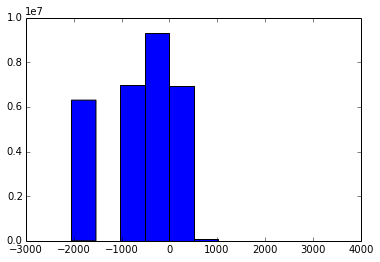

In [186]:
plt.hist(img.flatten())
plt.show()

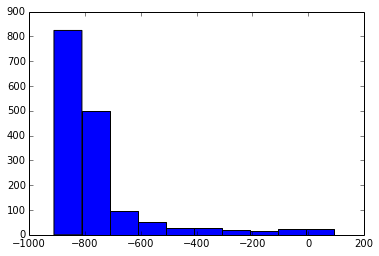

In [189]:
#img1 = np.clip(img[59,180:220,140:180],-1000,-600)
img1 = img[59,180:220,140:180]
plt.hist(img1.flatten())
plt.show()

In [190]:
img2 = np.clip(img1,-1000,-800)

In [195]:
from mpl_toolkits.mplot3d import Axes3D

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int16)

In [202]:
x,y = np.arange(0,img1.shape[0],1),np.arange(0,img2.shape[0],1)

In [203]:
x,y = np.meshgrid(x,y)

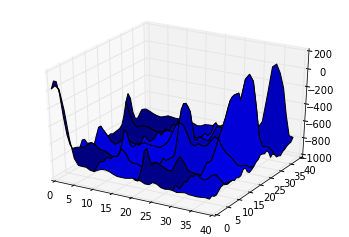

In [205]:
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot_surface(x,y,img1)

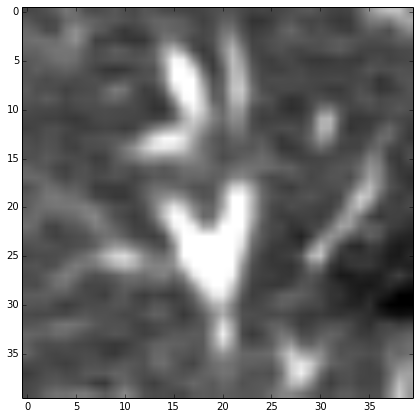

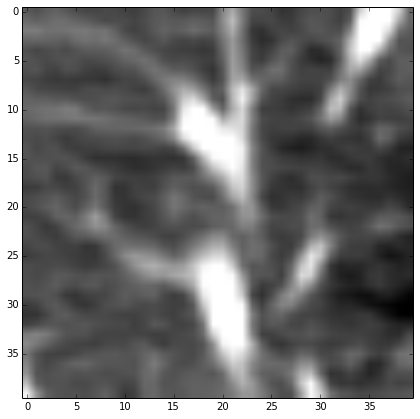

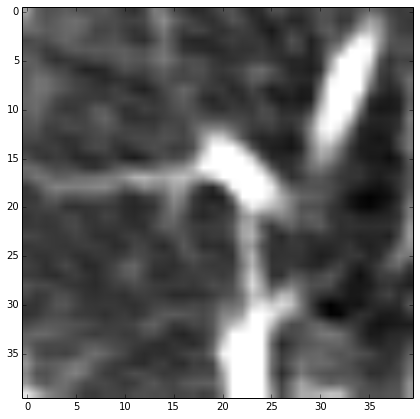

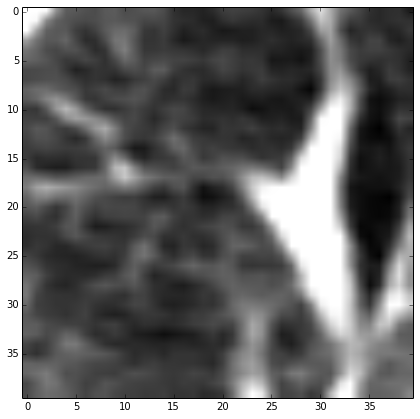

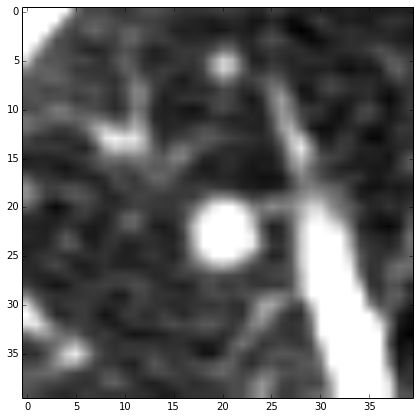

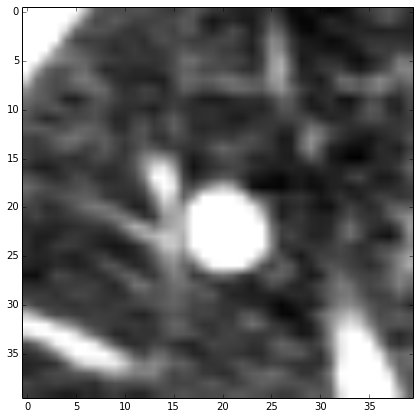

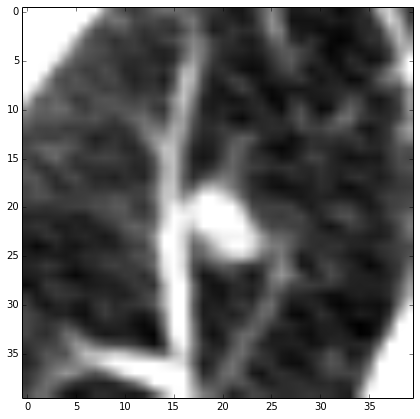

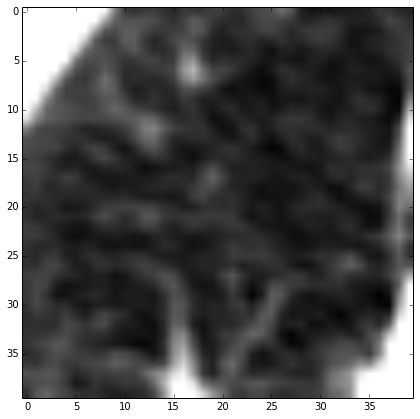

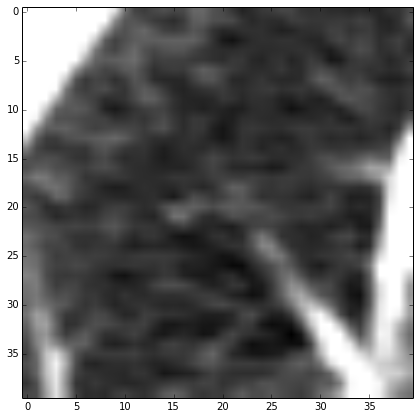

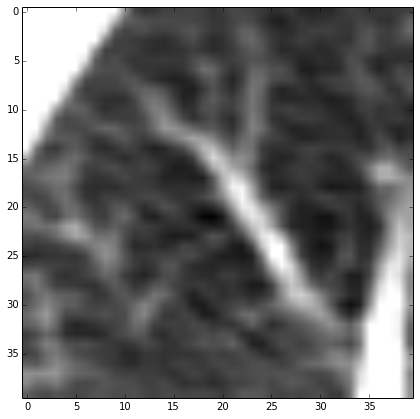

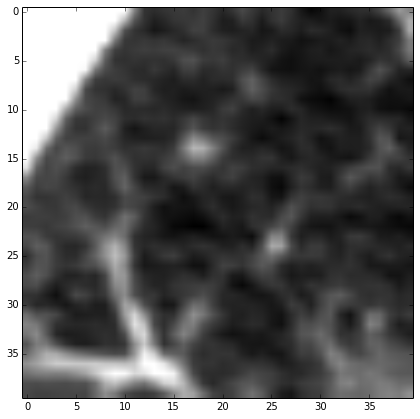

In [210]:

x = noduleVoxelCoords[0]
y = noduleVoxelCoords[1]
z = noduleVoxelCoords[2]
for a in range(55,66,1):
    plt.figure(figsize=(7,7))
    img1=img[a,180:220,140:180]
    plt.imshow(np.clip(img1,-1000,-500),cmap=cm.gray)
    plt.show()

# CANDIDATES

The candidates file is a csv file that contains nodule candidate per line. Each line holds the scan name, the x, y, and z position of each candidate in world coordinates, and the corresponding class. The list of candidates is provided for participants who are following the ‘false positive reduction’ track. Tutorial on how to view lesions given the location of candidates will be available on the Forum page.

The candidate locations are computed using three existing candidate detection algorithms [1-3]. As lesions can be detected by multiple candidates, those that are located <= 5 mm are merged. Using this method, 1120 out of 1186 nodules are detected with 551,065 false positives. For convenience, the corresponding class label (0 for non-nodule and 1 for nodule) for each candidate is provided in the list. It has to be noted that there can be multiple candidates per nodule.

In [246]:
m = np.random.random(3*3).reshape(3,3)
q,r = np.linalg.qr(m)
q

array([[-0.52179883,  0.42254777, -0.74106636],
       [-0.79265716, -0.56124812,  0.23810747],
       [-0.31531032,  0.71165577,  0.62779413]])

0.99999999999999989

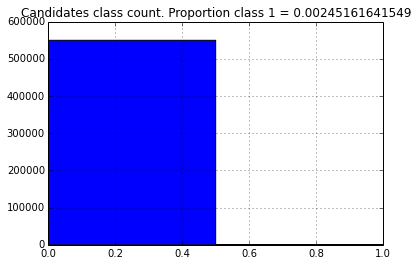

In [211]:
candidates = pd.read_csv("/home/msmith/luna16/CSVFILES/candidates.csv")
candidatesClass = candidates['class']
candidatesClass.hist(bins=2)
propClass1 = candidatesClass[candidatesClass==1].sum()/float(candidatesClass.size)
plt.title("Candidates class count. Proportion class 1 = "+str(propClass1))
plt.show()